TODO:
* Make model more sophisticated
* Add auxiliary loss on predicting class from not last layer
* Add weight sharing model
* Look and analize where models fail

## Description

The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective. 
It should be implemented with PyTorch only code, in particular without using other external libraries such as scikit-learn or numpy.

The goal of this project is to implement a deep network such that, given as input a series of 2×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import copy

from networks import NetSimple, NetAuxiliaryLoss
from utils import get_accuracy, grid_search, plot_accuracy_and_loss, test_samples

from dlc_practical_prologue import generate_pair_sets

## Data

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate_pair_sets(N) defined in the file
dlc_practical_prologue.py.

In [2]:
N = 1000

In [3]:
train_input, train_class, train_digit, test_input, test_class, test_digit = generate_pair_sets(N)

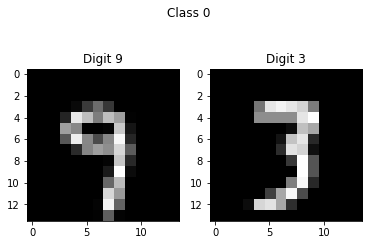

In [4]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_input[0][0], cmap="gray")
axs[0].set_title(f"Digit {train_digit[0][0].item()}")
axs[1].imshow(train_input[0][1], cmap="gray")
axs[1].set_title(f"Digit {train_digit[0][1].item()}")
fig.suptitle(f"Class {train_class[0].item()}")

plt.show()

In [5]:
train_loader = DataLoader(list(zip(train_input, train_class, train_digit)), batch_size=64)
test_loader = DataLoader(list(zip(test_input, test_class, test_digit)), batch_size=64)

## Objective

The goal of the project is to compare different architectures, and assess the performance improvement
that can be achieved through weight sharing, or using auxiliary losses. For the latter, the training can
in particular take advantage of the availability of the classes of the two digits in each pair, beside the
Boolean value truly of interest.

In [6]:
cross_entropy = nn.CrossEntropyLoss()
binary_cross_entropy = nn.BCEWithLogitsLoss()

## Model

In [7]:
# Task specific setup
input_channels = 2
output_class_channels = 2
output_digit_channels = 10

### Simple model

First let's implement simple model

In [8]:
net = NetSimple(input_channels, output_class_channels)

In [9]:
def simple_model_criterion(output, target):
    return cross_entropy(output, target)

In [10]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 12, 12]             114
         MaxPool2d-2              [-1, 6, 6, 6]               0
            Conv2d-3             [-1, 16, 4, 4]             880
         MaxPool2d-4             [-1, 16, 2, 2]               0
            Linear-5                   [-1, 50]           3,250
            Linear-6                    [-1, 2]             102
Total params: 4,346
Trainable params: 4,346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


### Model with weight sharing (Siamese network)

### Model with auxiliary loss

In [11]:
net = NetAuxiliaryLoss(input_channels, output_class_channels, output_digit_channels)

In [12]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 12, 12]             114
         MaxPool2d-2              [-1, 6, 6, 6]               0
            Conv2d-3             [-1, 16, 4, 4]             880
         MaxPool2d-4             [-1, 16, 2, 2]               0
            Linear-5                   [-1, 50]           3,250
            Linear-6                    [-1, 2]             102
            Linear-7                   [-1, 10]             510
            Linear-8                   [-1, 10]             510
Total params: 5,366
Trainable params: 5,366
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [13]:
def auxiliary_loss_criterion(output_class, target_class, output_digits, target_digits):
    return cross_entropy(output_class, target_class) \
            + cross_entropy(output_digits[0], target_digits[:, 0]) \
            + cross_entropy(output_digits[0], target_digits[:, 1])

## Training

In [14]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

cuda:0


In [15]:
def train(train_data_loader, test_data_loader,
          model, optimizer, criterion,
          epochs=10, print_info=False, print_every=5):
    """Trains model and computes accuracy on each test_every steps"""
    
    losses = []
    # Accuracy of class prediction
    accuracy_train_class = []
    accuracy_test_class = []
    # Accuracy of digit precition for model with auxiliary loss
    accuracy_train_digit = []
    accuracy_test_digit = []
    # Early stopping (saving the best model among epochs)
    best_model = None
    best_accuracy = 0
    
    for epoch in range(epochs):
        loss_epoch = 0
        
        # Train
        for (image, target_class, target_digits) in train_data_loader:
            optimizer.zero_grad()
            if model.predicts_digit: # For model with auxiliary loss
                output_class, output_digits = model(image)
                loss = criterion(output_class, target_class, output_digits, target_digits)
            else:
                output_class = model(image)
                loss = criterion(output_class, target_class)
            loss.backward()
            optimizer.step()
            
            loss_epoch += loss.item()
                
        losses.append(loss_epoch)
        
        # Test
        model.eval()
        with torch.no_grad():
            accuracy_train_data = get_accuracy(model, train_data_loader,
                                               calculate_accuracy_digit=model.predicts_digit)
            accuracy_test_data = get_accuracy(model, test_data_loader,
                                              calculate_accuracy_digit=model.predicts_digit)

            if model.predicts_digit: # For model with auxiliary loss
                acc_train_class, acc_train_digit = accuracy_train_data
                acc_test_class, acc_test_digit = accuracy_test_data

                accuracy_train_digit.append(acc_train_digit)
                accuracy_test_digit.append(acc_test_digit)
            else:
                acc_train_class = accuracy_train_data
                acc_test_class = accuracy_test_data

            accuracy_train_class.append(acc_train_class)
            accuracy_test_class.append(acc_test_class)
    
        if accuracy_test_class[-1] > best_accuracy:
            best_model = copy.deepcopy(model)
            
        if print_info and (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}/{epochs}, loss {losses[-1]:0.4f},",
                  f"class train/test accuracy: {accuracy_train_class[-1]}/{accuracy_test_class[-1]}",
                  f", digit train/test accuracy: {accuracy_train_digit[-1]}/{accuracy_test_digit[-1]}"
                  if accuracy_train_digit else "")
        
    return model, [accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit], losses

#### Simple net

In [16]:
model_params = {"input_channels": input_channels, 
                "output_channels": output_class_channels}

lr, reg = grid_search([0.05, 0.01, 0.005, 0.001], # Learning rates
                      [0.1, 0.5, 0.7, 1, 1.5], # Regularizations
                      train, train_loader, test_loader, 
                      NetSimple, model_params, simple_model_criterion, 
                      epochs=30, print_info=True)

Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.713
Learning rate: 0.0500, Regularization: 0.50, Test Accuracy: 0.526
Learning rate: 0.0500, Regularization: 0.70, Test Accuracy: 0.673
Learning rate: 0.0500, Regularization: 1.00, Test Accuracy: 0.578
Learning rate: 0.0500, Regularization: 1.50, Test Accuracy: 0.526
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.769
Learning rate: 0.0100, Regularization: 0.50, Test Accuracy: 0.786
Learning rate: 0.0100, Regularization: 0.70, Test Accuracy: 0.540
Learning rate: 0.0100, Regularization: 1.00, Test Accuracy: 0.608
Learning rate: 0.0100, Regularization: 1.50, Test Accuracy: 0.526
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.770
Learning rate: 0.0050, Regularization: 0.50, Test Accuracy: 0.803
Learning rate: 0.0050, Regularization: 0.70, Test Accuracy: 0.786
Learning rate: 0.0050, Regularization: 1.00, Test Accuracy: 0.738
Learning rate: 0.0050, Regularization: 1.50, Test Accuracy: 0.719
Learning r

In [17]:
epochs = 40
net_simple = NetSimple(input_channels, output_class_channels)

net_simple, accuracies, losses = train(train_loader, test_loader,
                                       model=net_simple,
                                       optimizer=optim.Adam(net_simple.parameters(), lr=lr, weight_decay=reg), 
                                       criterion=simple_model_criterion,
                                       epochs=epochs, print_info=True)

accuracy_train_class, accuracy_test_class, _, _ = accuracies

Epoch 5/40, loss 8.8978, class train/test accuracy: 0.717/0.743 
Epoch 10/40, loss 7.8477, class train/test accuracy: 0.771/0.728 
Epoch 15/40, loss 7.1917, class train/test accuracy: 0.805/0.766 
Epoch 20/40, loss 6.7177, class train/test accuracy: 0.831/0.787 
Epoch 25/40, loss 6.1973, class train/test accuracy: 0.851/0.79 
Epoch 30/40, loss 5.7254, class train/test accuracy: 0.862/0.791 
Epoch 35/40, loss 5.4585, class train/test accuracy: 0.875/0.806 
Epoch 40/40, loss 5.2396, class train/test accuracy: 0.886/0.811 


In [18]:
net_simple_filename = "net_simple.ckpt"
torch.save(net_simple.state_dict(), net_simple_filename)

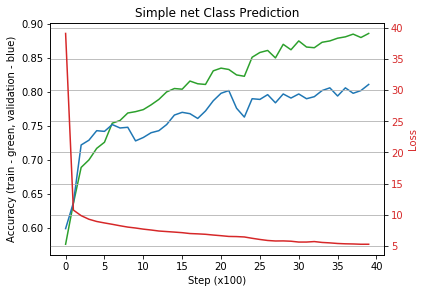

In [19]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="Simple net Class Prediction")

#### Auxiliary loss

In [20]:
model_params = {"input_channels": input_channels, 
                "output_class_channels": output_class_channels, 
                "output_digit_channels": output_digit_channels}

lr, reg = grid_search([0.05, 0.01, 0.005, 0.001], # Learning rates
                      [0.1, 0.5, 0.7, 1, 1.5], # Regularizations
                      train, train_loader, test_loader, 
                      NetAuxiliaryLoss, model_params, auxiliary_loss_criterion, 
                      epochs=30, print_info=True)

Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.637
Learning rate: 0.0500, Regularization: 0.50, Test Accuracy: 0.663
Learning rate: 0.0500, Regularization: 0.70, Test Accuracy: 0.567
Learning rate: 0.0500, Regularization: 1.00, Test Accuracy: 0.526
Learning rate: 0.0500, Regularization: 1.50, Test Accuracy: 0.526
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.765
Learning rate: 0.0100, Regularization: 0.50, Test Accuracy: 0.634
Learning rate: 0.0100, Regularization: 0.70, Test Accuracy: 0.566
Learning rate: 0.0100, Regularization: 1.00, Test Accuracy: 0.526
Learning rate: 0.0100, Regularization: 1.50, Test Accuracy: 0.539
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.767
Learning rate: 0.0050, Regularization: 0.50, Test Accuracy: 0.778
Learning rate: 0.0050, Regularization: 0.70, Test Accuracy: 0.785
Learning rate: 0.0050, Regularization: 1.00, Test Accuracy: 0.662
Learning rate: 0.0050, Regularization: 1.50, Test Accuracy: 0.553
Learning r

In [21]:
epochs = 40
net_auxiliary_loss = NetAuxiliaryLoss(input_channels, output_class_channels, output_digit_channels)

net_auxiliary_loss, accuracies, losses = train(train_loader, test_loader,
                                               model=net_auxiliary_loss,
                                               optimizer=optim.Adam(net_auxiliary_loss.parameters(), lr=lr, weight_decay=reg), 
                                               criterion=auxiliary_loss_criterion,
                                               epochs=epochs, print_info=True)

accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit = accuracies

Epoch 5/40, loss 76.3311, class train/test accuracy: 0.647/0.613 , digit train/test accuracy: 0.1525/0.1505
Epoch 10/40, loss 65.0753, class train/test accuracy: 0.684/0.647 , digit train/test accuracy: 0.2465/0.2425
Epoch 15/40, loss 61.3279, class train/test accuracy: 0.719/0.672 , digit train/test accuracy: 0.248/0.2315
Epoch 20/40, loss 59.0204, class train/test accuracy: 0.755/0.708 , digit train/test accuracy: 0.2415/0.233
Epoch 25/40, loss 57.5469, class train/test accuracy: 0.776/0.751 , digit train/test accuracy: 0.2555/0.2335
Epoch 30/40, loss 56.6479, class train/test accuracy: 0.795/0.77 , digit train/test accuracy: 0.254/0.2465
Epoch 35/40, loss 55.1629, class train/test accuracy: 0.808/0.77 , digit train/test accuracy: 0.2505/0.2295
Epoch 40/40, loss 55.0626, class train/test accuracy: 0.797/0.762 , digit train/test accuracy: 0.261/0.243


In [22]:
net_auxiliary_loss_filename = "net_auxiliary_loss.ckpt"
torch.save(net_auxiliary_loss.state_dict(), net_auxiliary_loss_filename)

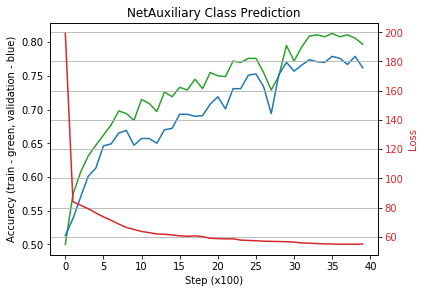

In [23]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="NetAuxiliary Class Prediction")

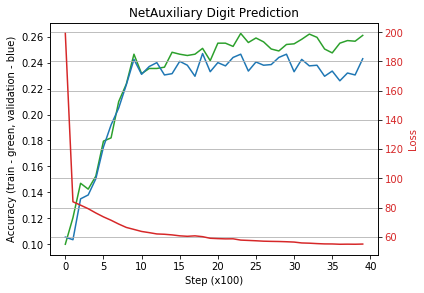

In [24]:
plot_accuracy_and_loss(accuracy_train_digit, accuracy_test_digit, losses, title="NetAuxiliary Digit Prediction")

### Test

#### Simple net

In [25]:
checkpoint = torch.load(net_simple_filename)
net_simple = NetSimple(input_channels, output_class_channels)
net_simple.load_state_dict(checkpoint)
# net_simple.to(device)

<All keys matched successfully>

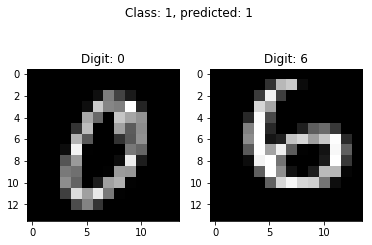

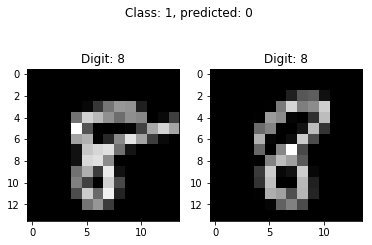

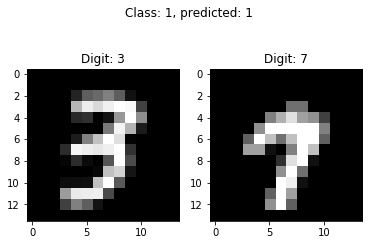

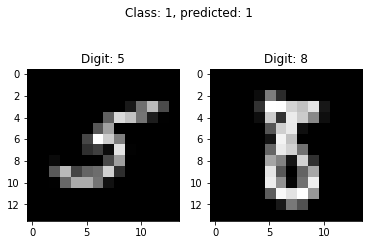

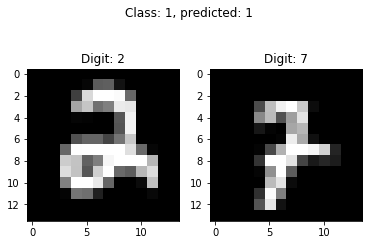

In [27]:
test_samples(net_simple, test_input, test_class, test_digit)

#### Weight sharing (Siamese network)

#### Auxiliary loss

In [28]:
checkpoint = torch.load(net_auxiliary_loss_filename)
net_auxiliary_loss = NetAuxiliaryLoss(input_channels, output_class_channels, output_digit_channels)
net_auxiliary_loss.load_state_dict(checkpoint)
# net_simple.to(device)

<All keys matched successfully>

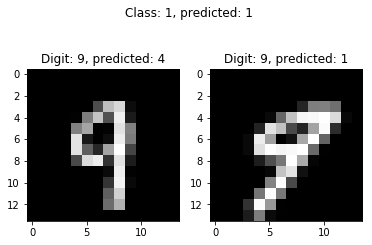

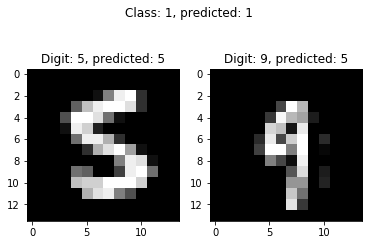

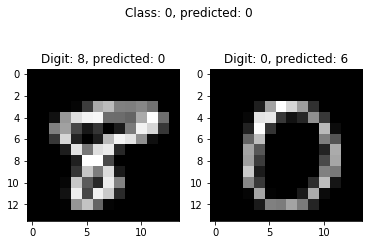

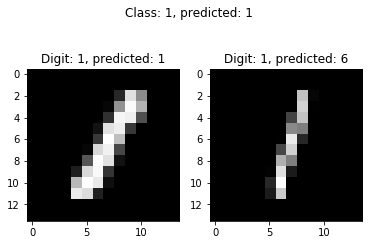

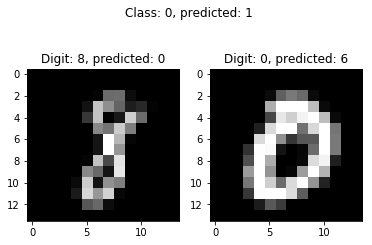

In [29]:
test_samples(net_auxiliary_loss, test_input, test_class, test_digit)

## Experiments

All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000
parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error
rate.

Performance estimates provided in your report should be estimated through 10+ rounds for each
architecture, where both data and weight initialization are randomized, and you should provide estimates
of standard deviations.